<a href="https://colab.research.google.com/github/Mario-RJunior/departamento-manutencao/blob/main/departamento_manutencao.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Departamento de Produção

## Importação das bibliotecas e da base de dados

In [1]:
# Importação das bibliotecas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from skimage import io
import tensorflow as tf
from tensorflow.keras import layers, optimizers
from tensorflow.keras.layers import Dense, Input, AveragePooling2D, Flatten, Dropout, MaxPool2D
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, Add, UpSampling2D, Concatenate
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import os

In [2]:
# Montando o drive do Google Colab
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Dataframe com todas as imagens
all_images_df = pd.read_csv('/content/drive/MyDrive/Departamento de manutenção/defect_and_no_defect.csv')

In [4]:
# Shape
all_images_df.shape

(12997, 2)

In [5]:
# Visualizando o dataframe
all_images_df

,ImageID,label
0,0002cc93b.jpg,1
1,0007a71bf.jpg,1
2,000a4bcdd.jpg,1
3,000f6bf48.jpg,1
4,0014fce06.jpg,1
...,...,...
12992,0482ee1d6.jpg,0
12993,04802a6c2.jpg,0
12994,03ae2bc91.jpg,0
12995,04238d7e3.jpg,0


Nota:

- Label 0: sem defeito.
- Label 1: com defeito.

In [6]:
# Dataframe com imagens com defeitos
defect_class_mask_df = pd.read_csv('/content/drive/MyDrive/Departamento de manutenção/train.csv')

In [7]:
# Shape
defect_class_mask_df.shape

(5748, 3)

In [8]:
# Porcentagem da quantidade de imagens com defeito
percent = (defect_class_mask_df.shape[0]/all_images_df.shape[0]) * 100
print('Percentual de imagens defeituosas: {}%'.format(percent))

Percentual de imagens defeituosas: 44.22559052088943%


In [9]:
# Visualizando o dataframe
defect_class_mask_df

,ImageId,ClassId,EncodedPixels
0,d2291de5c.jpg,1,147963 3 148213 9 148461 18 148711 24 148965 2...
1,78416c3d0.jpg,3,54365 3 54621 7 54877 10 55133 12 55388 14 556...
2,2283f2183.jpg,3,201217 43 201473 128 201729 213 201985 5086 20...
3,f0dc068a8.jpg,3,159207 26 159412 77 159617 128 159822 179 1600...
4,00d639396.jpg,3,229356 17 229595 34 229850 36 230105 37 230360...
...,...,...,...
5743,c12842f5e.jpg,3,88 23 342 29 596 34 850 39 1105 44 1361 46 161...
5744,2222a03b3.jpg,3,63332 4 63587 11 63841 20 64096 27 64351 35 64...
5745,b43ea2c01.jpg,1,185024 7 185279 11 185535 12 185790 13 186045 ...
5746,1bc37a6f4.jpg,3,303867 1 304122 3 304376 6 304613 3 304630 9 3...


In [10]:
# Valores únicos dos defeitos
defect_class_mask_df['ClassId'].unique()

array([1, 3, 4, 2])

## Exploração e visualização dos dados

In [11]:
# Quantidade de imagens com defeitos e sem defeitos
all_images_df['label'].value_counts()

1    7095
0    5902
Name: label, dtype: int64

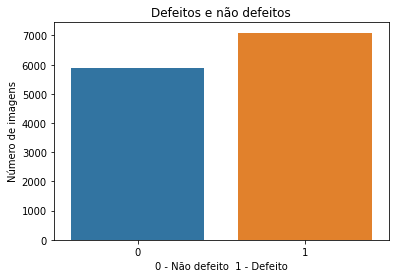

In [12]:
# Contagem gráficamente
# plt.figure(figsize=(10,10))
sns.countplot(data=all_images_df, x='label')
plt.ylabel('Número de imagens')
plt.xlabel('0 - Não defeito  1 - Defeito')
plt.title('Defeitos e não defeitos');

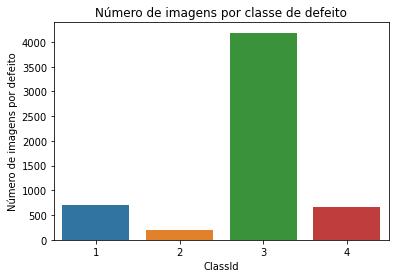

In [13]:
# Contagem dos tipos de erros
sns.countplot(data=defect_class_mask_df, x='ClassId')
plt.ylabel('Número de imagens por defeito')
plt.xlabel('ClassId')
plt.title('Número de imagens por classe de defeito');

Vemos que esta é uma base de dados extremamente desbalanceada.

Outra observação importante é o fato de que as imagens podem ter mais de um defeito e por isso é importante fazer uma contagem dos erros por imagem.

In [14]:
# Criando atributo para número de erros por imagem
defect_class_mask_df['mask'] = defect_class_mask_df['ClassId'].map(lambda x: 1)

In [15]:
# Visualizando o cabeçalho
defect_class_mask_df.head()

,ImageId,ClassId,EncodedPixels,mask
0,d2291de5c.jpg,1,147963 3 148213 9 148461 18 148711 24 148965 2...,1
1,78416c3d0.jpg,3,54365 3 54621 7 54877 10 55133 12 55388 14 556...,1
2,2283f2183.jpg,3,201217 43 201473 128 201729 213 201985 5086 20...,1
3,f0dc068a8.jpg,3,159207 26 159412 77 159617 128 159822 179 1600...,1
4,00d639396.jpg,3,229356 17 229595 34 229850 36 230105 37 230360...,1


In [16]:
# Agrupando por Imagem e contabilizando os erros de cada uma
defect_type = defect_class_mask_df.groupby(['ImageId'])['mask'].sum()
defect_type

ImageId
0002cc93b.jpg    1
0007a71bf.jpg    1
000a4bcdd.jpg    1
000f6bf48.jpg    1
0014fce06.jpg    1
                ..
ffcf72ecf.jpg    1
fff02e9c5.jpg    1
fffe98443.jpg    1
ffff4eaa8.jpg    1
ffffd67df.jpg    1
Name: mask, Length: 5474, dtype: int64

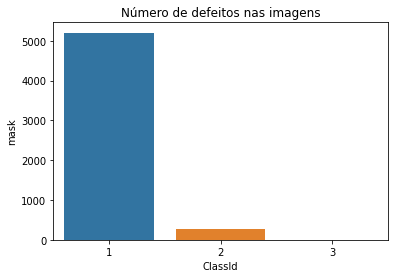

In [17]:
# Gráfico da quantidade de erros por imagens
sns.barplot(x=defect_type.value_counts().index, y=defect_type.value_counts())
plt.xlabel('ClassId')
plt.title('Número de defeitos nas imagens');

Agora iremos visualizar algumas imagens da base de treinamento.

In [18]:
# Definindo o caminho das imagens
train_dir = '/content/drive/MyDrive/Departamento de manutenção/train_images'

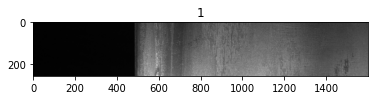

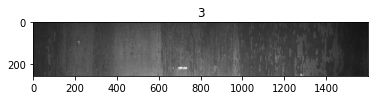

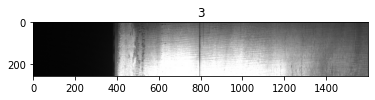

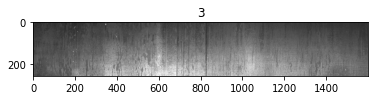

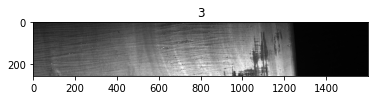

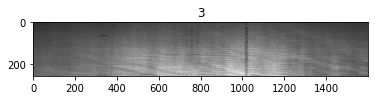

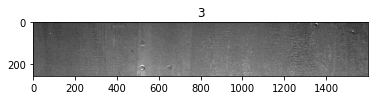

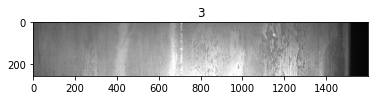

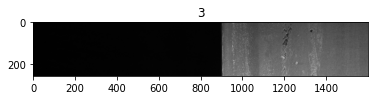

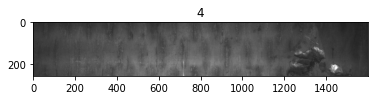

In [19]:
# Percorrendo algumas imagens
for i in range(10):
  img = io.imread(os.path.join(train_dir, defect_class_mask_df['ImageId'][i]))
  plt.figure()
  plt.title(defect_class_mask_df['ClassId'][i])
  plt.imshow(img)

In [20]:
pwd

'/content'

In [21]:
cd /content/drive/MyDrive/Departamento de manutenção

/content/drive/MyDrive/Departamento de manutenção


In [22]:
pwd

'/content/drive/MyDrive/Departamento de manutenção'

In [23]:
ls

defect_and_no_defect.csv           ResUNet-steel.json
__pycache__/                       test.csv
resnet-50-steel.json               train.csv
resnet-classifier-model.json       train_images/
resnet-weights.hdf5                utilities.py
resunet-segmentation-model.json    weights.hdf5
resunet-segmentation-weights.hdf5  weights_seg.hdf5


In [24]:
from utilities import rle2mask

In [25]:
# Visualizando novamente o dataframe com os defeitos
defect_class_mask_df

,ImageId,ClassId,EncodedPixels,mask
0,d2291de5c.jpg,1,147963 3 148213 9 148461 18 148711 24 148965 2...,1
1,78416c3d0.jpg,3,54365 3 54621 7 54877 10 55133 12 55388 14 556...,1
2,2283f2183.jpg,3,201217 43 201473 128 201729 213 201985 5086 20...,1
3,f0dc068a8.jpg,3,159207 26 159412 77 159617 128 159822 179 1600...,1
4,00d639396.jpg,3,229356 17 229595 34 229850 36 230105 37 230360...,1
...,...,...,...,...
5743,c12842f5e.jpg,3,88 23 342 29 596 34 850 39 1105 44 1361 46 161...,1
5744,2222a03b3.jpg,3,63332 4 63587 11 63841 20 64096 27 64351 35 64...,1
5745,b43ea2c01.jpg,1,185024 7 185279 11 185535 12 185790 13 186045 ...,1
5746,1bc37a6f4.jpg,3,303867 1 304122 3 304376 6 304613 3 304630 9 3...,1


In [26]:
# Shape das imagems
img.shape

(256, 1600, 3)

In [27]:
# Número de pixels
256 * 1600 * 3

1228800

In [28]:
# Encoded Pixels para imagem de índice 20
print(len(defect_class_mask_df['EncodedPixels'][20]))
print()
defect_class_mask_df['EncodedPixels'][20]

452



'361364 18 361613 42 361862 55 362112 67 362337 4 362364 102 362589 13 362616 118 362842 21 362868 134 363095 170 363328 13 363347 193 363567 2424 366005 224 366272 199 366539 178 366806 157 367073 135 367339 115 367604 96 367868 77 368129 61 368385 50 368641 39 368897 28 369153 17 369409 6 369665 1 392092 53 392343 64 392593 70 392844 74 393095 79 393336 94 393579 107 393832 109 394086 111 394347 103 394613 88 394878 21 394909 42 395144 7 395186 16'

In [29]:
# Escolhendo uma imagem aleatória
image_index = 20
mask = rle2mask(defect_class_mask_df['EncodedPixels'][image_index], 
                img.shape[0], 
                img.shape[1])

In [30]:
# Visualizando o tamanho de mask
mask.shape

(256, 1600)

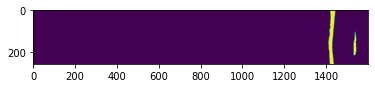

In [31]:
# Visualizando a imagem
plt.imshow(mask)

(256, 1600, 3)

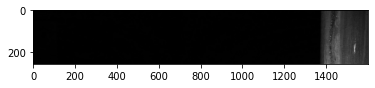

In [32]:
# Visualização da imagem original
img = io.imread(os.path.join(train_dir, defect_class_mask_df['ImageId'][image_index]))
plt.imshow(img)
img.shape